
# CIENCIA Y ANALITICA DE DATOS
## Actividad Semanal -- 7 Regresiones y K means
##Notebook 2. K means. 

###Profesor Titular: Maria de la Paz Rico Fernandez
###Profesor Tutor: Juan Miguel Meza Méndez

###Alumno: Samuel Elías Flores González
###Matrícula: A01793668

###Fecha: 9/Noviembre/2022

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [60]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [62]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [63]:
df.head()

,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [65]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

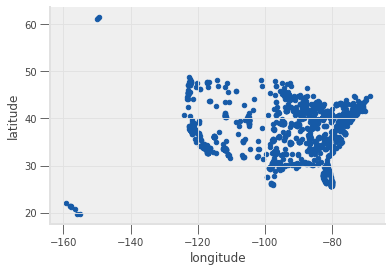

In [66]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [67]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [68]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [69]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [70]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [71]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [72]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

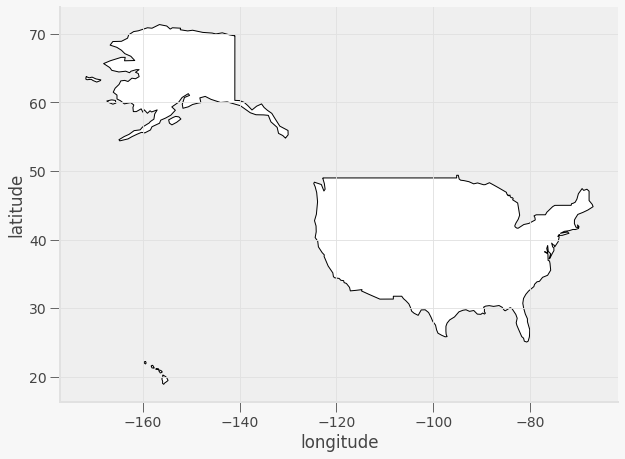

In [73]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

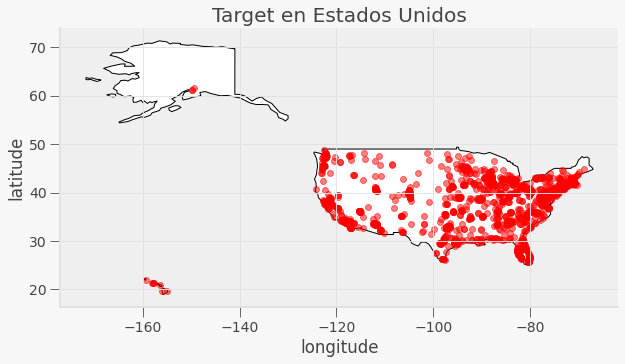

In [74]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

In [75]:
#tu codigo aquí

In [76]:
from sklearn.cluster import KMeans  #Importamos librerias
from sklearn.datasets import make_blobs

In [77]:
list_geo=list(zip(df.longitude, df.latitude)) #Definimos lista con coordenadas
list_geo

[(-86.80417369999999, 33.2242254),
 (-86.98977789999999, 33.3345501),
 (-87.89593169999999, 30.6028747),
 (-86.9715595, 34.5601477),
 (-85.4464222, 31.2660613),
 (-87.6339077, 34.8420853),
 (-86.80555729999999, 33.6060399),
 (-87.6799946, 30.3039796),
 (-86.77509979999999, 33.467142),
 (-86.7562505, 34.7488201),
 (-86.1600739, 32.3606937),
 (-85.4050434, 32.6204324),
 (-85.7846536, 33.6092005),
 (-86.3957891, 32.4570652),
 (-87.51825509999999, 33.1923759),
 (-86.7125552, 33.425259),
 (-86.6376483, 33.6054494),
 (-86.8532462, 33.3616601),
 (-86.68163709999999, 34.7446779),
 (-86.5443483, 34.674648),
 (-88.1204442, 30.6709831),
 (-88.2260919, 30.6734013),
 (-149.4029599, 61.5779193),
 (-149.745967, 61.2299524),
 (-149.8814512, 61.13006249999999),
 (-114.5918998, 35.0528237),
 (-111.6591788, 35.1840575),
 (-111.7184273, 33.5733931),
 (-110.9601638, 32.3990239),
 (-112.4315678, 34.549193),
 (-111.6407335, 33.2552871),
 (-110.2558558, 31.5561559),
 (-112.3537192, 33.6368072),
 (-112.269511,

In [78]:
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [79]:
centers_b = list_geo

X, y = make_blobs(n_samples=1839, centers=centers_b, cluster_std=0.20,
                  random_state=7)

In [80]:
print(X)

[[ -81.4511825    32.10571602]
 [ -86.52523118   36.01168885]
 [-123.13073166   45.71017966]
 ...
 [-122.75515253   45.67169298]
 [ -71.68181402   41.71902706]
 [ -73.6808068    40.98018108]]


In [81]:
X.shape

(1839, 2)

In [82]:
kmeans = KMeans(n_clusters=100, random_state=2) #Definimos objeto kmeans con parametros n_clusters=3, random_state=2
y_pred = kmeans.fit_predict(X) #Predecimos salida

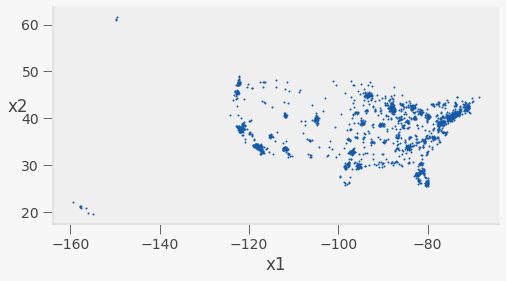

In [83]:
#Definimos funcion 
def clusters_plot (X, y=None):

    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("x1")
    plt.ylabel("x2", rotation=0)


#Llamamos funcion y mostramos grafica
plt.figure(figsize=(8, 4))
clusters_plot(X)
plt.gca().set_axisbelow(True)
plt.grid()
plt.show()

In [84]:
y_pred #Mostramos y predecida

array([72,  9, 43, ..., 43, 22,  2], dtype=int32)

In [85]:
Clusters=kmeans.cluster_centers_ 
Clusters

array([[ -90.57348808,   44.3374129 ],
       [-118.3862064 ,   34.101083  ],
       [ -73.98942342,   40.80889738],
       [ -94.41831329,   32.50345138],
       [ -82.32588543,   27.61248766],
       [-158.11848117,   21.32786001],
       [ -84.54706835,   38.99060265],
       [-122.23774109,   47.56812314],
       [-104.93516906,   39.76415781],
       [ -86.82418042,   35.96350956],
       [ -80.60054577,   35.42912521],
       [-111.9452188 ,   33.56281986],
       [ -94.53510675,   45.49149769],
       [-149.74717975,   61.30730418],
       [-122.24720144,   37.96291405],
       [ -77.95630564,   37.79309744],
       [ -97.35204471,   38.02211275],
       [ -81.69119602,   41.30468896],
       [ -88.97529404,   40.19202103],
       [-111.73773207,   43.41225177],
       [ -95.41198058,   29.80503583],
       [ -88.39049268,   43.07888683],
       [ -71.30513169,   41.8289301 ],
       [ -98.45760596,   29.56708346],
       [ -87.38843229,   30.51350191],
       [-106.63113126,   

In [86]:
#Definimos funcion para graficar el cluster de tiendas
def map_plot(Clusters):

    Clusters = pd.DataFrame(Clusters, columns = ['Lat','Long'])
    Clusters["Coordinates"] = list(zip(Clusters.Lat, Clusters.Long))
    Clusters["Coordinates"] = Clusters["Coordinates"].apply(Point)
    gdf = gpd.GeoDataFrame(Clusters, geometry="Coordinates")

    fig, gax = plt.subplots(figsize=(10,10))

    world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

    gdf.plot(ax=gax, color='Blue', alpha = 0.5)

    gax.set_xlabel('longitude')
    gax.set_ylabel('latitude')
    gax.set_title('Target en Estados Unidos')

    gax.spines['top'].set_visible(False)
    gax.spines['right'].set_visible(False)

    return plt.show()

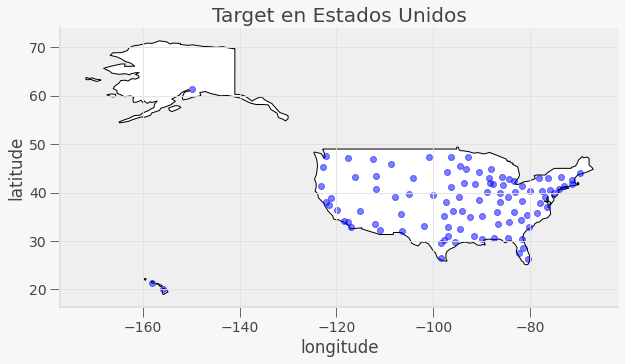

In [87]:
map_plot(Clusters) #Mostramos 100 tiendas

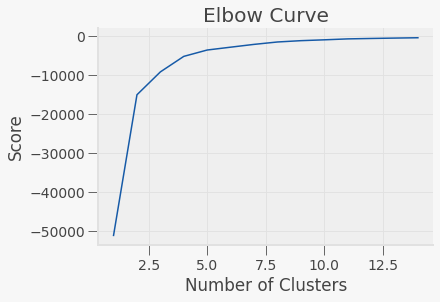

In [97]:
#Definimos rango de busqueda de valor
K_clusters_rango = range(1,15)

#Buscamos valor de kmean en rango
kmeans_2 = [KMeans(n_clusters=i) for i in K_clusters_rango] 

#Definimos eje x y y
Y_axis = latlong[['latitude']]
X_axis = latlong[['longitude']]

#Determina score (valor de distancia de centroide con sus vecinos, entre mas vecinos valor mas chico)
score = [kmeans_2[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans_2))] 


#Graficamos
plt.plot(K_clusters_rango, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [100]:
kmeans = KMeans(n_clusters = 3, init ='k-means++') #definimos objeto Kmeans con 3 clusters

#Entrenamos modelo
kmeans.fit(latlong[latlong.columns[0:2]])

#Almacenamos resultado
labels_kmean = kmeans.labels_
labels_kmean

array([0, 0, 0, ..., 2, 0, 2], dtype=int32)

In [103]:
#Extraemos solo valores de ubicacion del dataframe
X = df[["longitude","latitude"]]

#Entrenamos modelo
kmeans = KMeans(n_clusters=3).fit(X) 

#Definimos centroides de kmeans
centroids = kmeans.cluster_centers_ 

#Predecimos salida
labels = kmeans.predict(X) 

#centroides
C = kmeans.cluster_centers_

#Definimos dataframe
Center_DF = pd.DataFrame(C) 

#Creamos lista con coordenadas
Center_DF["Coordinates"] = list(zip(Center_DF[0], Center_DF[1])) 
Center_DF["Coordinates"] = Center_DF["Coordinates"].apply(Point) 


gdf_C = gpd.GeoDataFrame(Center_DF, geometry="Coordinates") 
gdf_C

,0,1,Coordinates
0,-93.327172,37.980063,POINT (-93.32717 37.98006)
1,-78.569908,37.789554,POINT (-78.56991 37.78955)
2,-118.624473,37.487342,POINT (-118.62447 37.48734)


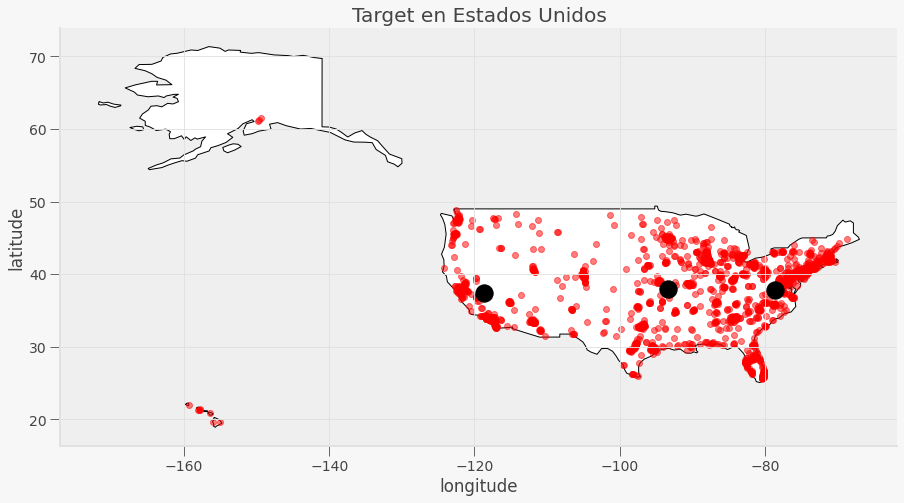

In [91]:
fig, gax = plt.subplots(figsize=(15,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white') #Aqui traemos el mapa de los unites

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5) #Aqui grafica los datos originales
gdf_C.plot(ax=gax, color='black', alpha = 1, markersize = 300) #Aqui grafica los datos de nuestro dataset de arriba

#Grafica resultado
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [93]:
gdf_C #Coordenadas de los 3 almacenes

,0,1,Coordinates
0,-78.569908,37.789554,POINT (-78.56991 37.78955)
1,-118.657146,37.481742,POINT (-118.65715 37.48174)
2,-93.347476,37.982702,POINT (-93.34748 37.98270)


In [108]:
#Importamos libreria
from pandas.core.internals.concat import concat_arrays

#Determinamos las localizacion/coordenadas de los almacenes
Location1 = str(gdf_C[1][0]) + ", " + str(gdf_C[0][0]) 
print(Location1)
Location2 = str(gdf_C[1][1]) + ", " + str(gdf_C[0][1])
print(Location2)
Location3 = str(gdf_C[1][2]) + ", " + str(gdf_C[0][2])
print(Location3)



37.98006260590112, -93.32717230430622
37.789554004474006, -78.56990807484885
37.48734203064935, -118.62447331844157


In [110]:
#¿qué ciudad es?

#Importamos libreria
from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim 
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="my-application") 

#Ingresamos coordenadas de los 3 almacenes
Locations = [Location1, Location2, Location3] 

for i in Locations:

  #Definimos la ciudad usando las coordenadas
  location = geolocator.reverse(i)
  print('Localizacion de almacen en ---', location.address)


Localizacion de almacen en --- Hickory County, Missouri, United States
Localizacion de almacen en --- Langhorne Road, Totier Hills, Albemarle County, Virginia, 22946, United States
Localizacion de almacen en --- Paradise Estates, Mono County, California, United States


In [111]:
#¿a cuantas tiendas va surtir? 

##Determinamos la cantidad de tiendas que le corresponderan a cada cluster
latlong['kmeans'] = kmeans.labels_  
latlong.loc[:, 'kmeans'].value_counts() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


1    826
0    628
2    385
Name: kmeans, dtype: int64

In [107]:
#¿sabes a que distancia estará?

#Determinamos distancias entre almacenes
distancia12 = str(geodesic(Location1, Location2).miles)
print("\nDistancia entre el almacen 1 y 2 : ", distancia12, " mi \n") 

distancia23 = str(geodesic(Location2, Location3).miles)
print("Distancia entre el almacen 2 y 3 : ", distancia23, " mi \n")




Distancia entre el almacen 1 y 2 :  2181.490837424155  mi 

Distancia entre el almacen 2 y 3 :  1382.4721323777403  mi 



Encuentra las latitudes y longitudes de los almacenes, 

**¿qué ciudad es?**

1-Localizacion de almacen en --- Langhorne Road, Totier Hills, Albemarle County, Virginia, 22946, United States

2-Localizacion de almacen en --- Mono County, California, United States

3-Localizacion de almacen en --- State Highway Y, Hickory County, Missouri, 65732, United States


**¿a cuantas tiendas va surtir?**

1-   827 Tiendas

2-    627 Tiendas

3-    385 Tiendas


**¿sabes a que distancia estará?**

Distancia entre el almacen 1 y 2 :  2181.49  mi 

Distancia entre el almacen 2 y 3 :  1382.47  mi 

**¿Cómo elegiste el número de almacenes?**

Haciendo uso de la grafica de codo, y valiendonos del valor de score graficado. A medida que el score era mayor y negativo, el almacen tenia menos tiendas a sus alrededores. es por esa razon que se escogieron 3 tiendas, las cuales nos presenta un valor de 10,000, mientras que a partir de el almacen 4 la diferencia entre el valor de score es muy pequeña, por lo cual no se consideraria conveniente hacer uso de ese 4to almacen. 

**¿qué librerías nos pueden ayudar a graficar este tipo de datos?**

Geopandas es una librería de gran utilidad para graficar casos como este en particular, donde es requerido trabajar con datos geo espaciales. esta libreria combina las capacidades de pandas and shapely. Geopandas nos permite realizar de forma sencilla operaciones geo espaciales en python sin la necesidad de utilizar bases de datos espaciales tales como PostGIS.

**¿Consideras importante que se grafique en un mapa?, ¿por qué?**

Si, es de gran importancia la visualización de los resultados, esto debido a que el ser humano es un ser visual. La visión es el sentido que más influencia tiene en nuestra toma de desiciones. Por tal razón, el hecho de contar con un mapa de los datos de trabajo, nos permitirá realizar un mejor análisis del problema en cuestión. Además de facilitarnos la comprensión de los datos, acelerando el proceso de la toma de desiciones.

**Agrega las conclusiones**

Hemos aprendido como resolver un problema que pueden llegar a presentar las cadenas de suministros mediante el uso de los algoritmos de agrupamiento o clustering.

Gracias a KMean se pudo determninar la cantidad y ubicación mas óptima de almacenes para suministrar o abastecer a las diferentes tiendas distribuidas a lo largo de Estados Unidos.

En este ejercicio en particular, observamos que nuestro resultado consistió en 3 tiendas distribuidas al este, centro y oeste del país. Según la gráfica de codo que mostramos anteriormente, determinamos que 2 almacenes eran muy poco, ya que habría varias tiendas que quedarían retiradas, mientras que 4 almacenes no mejoraban de manera significativa el score graficado. 



**Referencias:**

[1] Géron, A. (s. f.). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition. O’Reilly Online Learning. https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/